# CS4277/CS5477 Lab 2: Camera Calibration

In [1]:
import cv2
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import lab2
%matplotlib inline

### Introduction
In this assignment, you will implement Zhenyou Zhang’s camera calibration. 
The extrincs and intrincs of a camera are estimated from three images of a model plane. 
You will first estimate the five intrinsic parameters (focal length, principle point, skew) and six extrinsic parameters (three for rotation and three for translation) by a close-form solution. 
Then you will estimate five distortion parameters and also finetune all parameters by minimize the total reprojection error. 

This assignment is worth **15%** of the final grade.

References:
* Lecture 4 
* Zhengyou Zhang. A Flexible New Technique for CameraCalibration

### Instructions
This workbook provides the instructions for the assignment, and facilitates the running of your code and visualization of the results. For each part of the assignment, you are required to **complete the implementations of certain functions in the accompanying python file** (`lab2.py`).

To facilitate implementation and grading, all your work is to be done in that file, and **you only have to submit the .py file**.

Please note the following:
1. Fill in your name, email, and NUSNET ID at the top of the python file.
2. The parts you need to implement are clearly marked with the following:

    ```
    """ YOUR CODE STARTS HERE """

    """ YOUR CODE ENDS HERE """
    ```
    
    , and you should write your code in between the above two lines.
3. Note that for each part, there may certain functions that are prohibited to be used. It is important **NOT to use those prohibited functions** (or other functions with similar functionality). If you are unsure whether a particular function is allowed, feel free to ask any of the TAs.


### Submission Instructions
Upload your completed `lab2.py` onto the relevant work bin in Luminus.


---
## Part 1: Load and Visualize Data

In this part, you will get yourself familiar with the data by visualizing them. The data includes three images of a planar checkerboard (CalibIm1-3.tif) and the correpsonding corner locations in each image (data1-3.txt). The 3D points of the model are stored in Model.txt. Note that only $X$ and $Y$ coordinates are provided because we assume that the model plane is on $Z=0$. You can visualize the data with the provided code below.

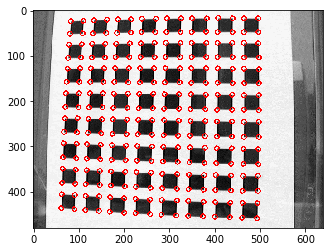

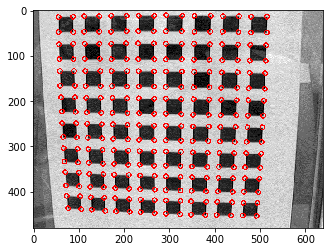

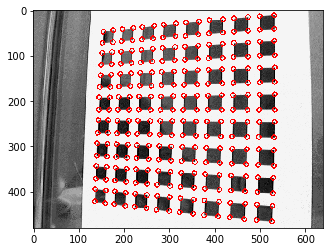

In [2]:
Model = np.loadtxt('./zhang_data/Model.txt')
X = Model[:, 0::2].reshape([1, -1])
Y = Model[:, 1::2].reshape([1, -1])
pts_model = np.vstack([X, Y])
pts_model_homo = np.concatenate([pts_model, np.ones([1, pts_model.shape[1]])], axis= 0)
pts_2d = []
for i in range(3):
    data = np.loadtxt('./zhang_data/data{}.txt'.format(i+1))
    img = cv2.imread('./zhang_data/CalibIm{}.tif'.format(i+1))
    x = data[:, 0::2].reshape([1, -1])
    y = data[:, 1::2].reshape([1, -1])
    pts_2d.append(np.vstack([x, y]))
    
    # Visualize images and the corresponding corner locations.
    for j in range(x.shape[1]):
        cv2.circle(img, (np.int32(x[0, j]), np.int32(y[0, j])) , 5, (255, 0, 0), 2)
    plt.figure()
    plt.imshow(img)
    

---
## Part 2: Estimate the Intrinsic Parameters

In this part, you will estimate the the intrinsics, which inludes focal length, skew and principle point.You will firstly estimate the homography between each observed image and the 3D model. Note that you are allowed to use `cv2.findHomography()` here to since you already implemented it in lab1. Each view of the checkerboard gives us two constraints: 
$$
\mathbf{v}\mathbf{b} = \mathbf{0},
$$
where $\mathbf{v}$ is $2 \times 6$ matrix made up of the homography terms. Given three observations, we can get :
$$
\mathbf{V}\mathbf{b} = \mathbf{0},
$$
where $\mathbf{V}$ is a $6 \times 6$ matrix obtained from stacking all constraints together. The solution can be obtained by taking the right null-space of $\mathbf{V}$, which is the right singular vector corresponding to the smallest singular value of $\mathbf{V}$. 

**Implement the following function(s): `cv2.calibrateCamera()`**

* <u>You may use the following functions</u>:
  `cv2.findHomography(), np.linalg.svd()`
* <u>Prohibited Functions</u>:
   `cv2.calibrateCamera()`

---
## Part 3: Estimate the Extrinsic Parameters

In this part, you will estimate the extrinsic parameters based on the intrinsic matrix $\mathbf{A}$ you obtained from Part 2. You can compute the rotation and translation according to:
$$
\mathbf{r}_1 = \lambda \mathbf{A}^{-1} \mathbf{h}_1 \\
\mathbf{r}_2 = \lambda \mathbf{A}^{-1} \mathbf{h}_2 \\
\mathbf{r}_3 =  \mathbf{r}_{1} \times \mathbf{r}_2 \\
\mathbf{t} = \lambda \mathbf{A}^{-1} \mathbf{h}_3.
$$
$\lambda = 1/\lVert\mathbf{A}^{-1} \mathbf{h}_1\rVert = 1/\lVert\mathbf{A}^{-1} \mathbf{h}_2\rVert$, and $\mathbf{h}_i$ represents the $i^{th}$ column of the homography $\mathbf{H}$. Note that the rotation matrix $\mathbf{R} = [\mathbf{r}_1, \mathbf{r}_1, \mathbf{r}_1]$ does not in general satisfy the properties of a rotation matrix. Hence, you will use the provided function `convt2rotation()` to estimate the best rotation matrix. The detail is given in the supplementary of the reference paper.

* <u>You may use the following functions</u>:
  `np.linalg.svd(), np.linalg.inv(),np.linalg.norm(), convt2rotation`

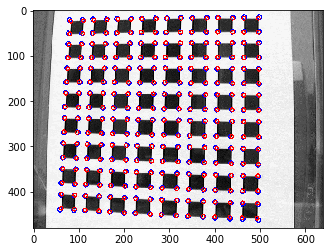

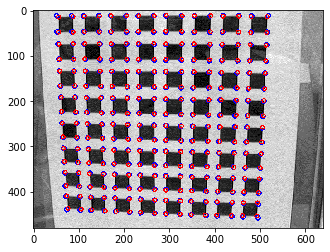

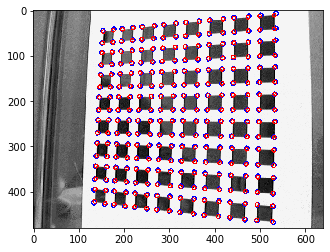

In [3]:
R_all, T_all, K = lab2.init_param(pts_model, pts_2d)
A = np.array([K[0], K[1], K[2], 0, K[3], K[4], 0, 0, 1]).reshape([3, 3])
img_all = []
for i in range(len(R_all)):
    R = R_all[i]
    T = T_all[i]
    points_2d = pts_2d[i]
    trans = np.array([R[:, 0], R[:, 1], T]).T
    points_rep = np.dot(A, np.dot(trans, pts_model_homo))
    points_rep = points_rep[0:2] / points_rep[2:3]
    img = cv2.imread('./zhang_data/CalibIm{}.tif'.format(i + 1))
    for j in range(points_rep.shape[1]):
        cv2.circle(img, (np.int32(points_rep[0, j]), np.int32(points_rep[1, j])), 5, (0, 0, 255), 2)
        cv2.circle(img, (np.int32(points_2d[0, j]), np.int32(points_2d[1, j])), 4, (255, 0, 0), 2)
    plt.figure()
    plt.imshow(img)

Up to now, you already get a rough estimation of the intrinsic and extrinsic parameters. You can check your results with the provided code, which visualizes the reprojections of the corner locations with the estimated parameters. You will find that the points that are far from the center of the image (the four corners of the checkerboard) are not as accurate as points at the center. This is because we did not consider the distortion parameters in this step. 

---
## Part 4: Estimate All Parameters 

In this part, you will estimate all parameters by minimize the total reprojection error:
$$
\underset{{\mathbf{K, R, t,\kappa }}}{\operatorname{argmin}}\sum_{i=1}^n \sum_{j=1}^m \lVert \mathbf{x}_{ij} - \pi( \mathbf{K, R, t,\kappa}, \mathbf{X}_j) \rVert.
$$
$\mathbf{K, R, t}$ are the intrinsics and extrinsices, which are initialized with estimation from Part 3. $\mathbf{\kappa}$ represents the five distortion parameters and are initialized with zeros. $\mathbf{X}_j$ and $\mathbf{x}_{ij}$ represent the 3D model and the corresponding 2D observation. 

Note that you will use the function `least_squares()` in `scipy` to minimize the reprojection error and find the optimal parameters. During the optimization process, the rotation matrix $\mathbf{R}$ should be represented by a 3-dimensional vector by using the provided function `matrix2vector()`. We provide the skeleton code of how to use the function `least_squares()` below. 

The key step of the optimization is to define the error function `error_fun()`, where the first parameter `param` is the parameters you will optimize over.  The `param` in this example includes: intrinsics (0-5), distortion (5-10), extrinsics (10-28). The extrincs consist of three pairs of rotation $\mathbf{s}$ and translation $\mathbf{t}$ because we have three views. The rotation $\mathbf{s}$ is the 3-dimensional vector representation, which you can convert back to a rotation matrix with provided function 
`vector2matrix()`. 

You will have to consider the distortion when computing the reprojection error. Let $\mathbf{x} = (x, y)$ be the normalized image coordinate, namely the `points_ud_all` in the code. The radial distortion is given by:
$$
\text{x}_\text{r} = \begin{bmatrix} x_r \\ y_r \end{bmatrix} = (1+ \kappa_1 r^2 + \kappa_2 r^4 + \kappa_5 r^6)\begin{bmatrix} x \\ y \end{bmatrix},
$$
where $r^2 = x^2 + y^2$ and $\kappa_1, \kappa_2, \kappa_5$ are the radial distortion parameters. The tangential distortion is given by :
$$
\text{dx} = \begin{bmatrix} 2 \kappa_3 x y + \kappa_4 (r^2 + 2x^2) \\ \kappa_3(r^2 + 2y^2) + 2 \kappa_4 x y \end{bmatrix}, 
$$
where $\kappa_3, \kappa_4$ are the tangential distortion parameters. FInally, the image coordinates after distortion is given by :
$$
\text{x}_\text{d} = \text{x}_\text{r} + \text{dx}.
$$

The optimization converges when the error does not change too much. Note that you will decide the `iter_num` according to the error value by yourself. You can verify the optimal parameters by visualizing the points after distortion. The function `visualize_distorted()` is an example of how to visualize the the points after distortion in image. You will find that the points that are far from the center of the image is more accurate than the estimation from Part 3.

In [ ]:
iter_num = 20
param = []
param.extend(K)
k = np.zeros([5,])
param.extend(k)
for i in range(len(R_all)):
    S = lab2.matrix2vector(R_all[i])
    param.extend(S)
    param.extend(T_all[i])
param = np.array(param)

for i in range(iter_num):
    opt = least_squares(lab2.error_fun, param, args=(pts_model, pts_2d))
    param = opt.x
    error = opt.cost
    print('iteration:', i, 'error:', error)    
lab2.visualize_distorted(param, pts_model, pts_2d)    

iteration: 0 error: 18.677942761092478
iteration: 1 error: 18.237358508277417
iteration: 2 error: 18.208412180634387
iteration: 3 error: 18.201095945700605
iteration: 4 error: 18.197434080693718
iteration: 5 error: 18.194535485535244
iteration: 6 error: 18.192629637130793
iteration: 7 error: 18.189420080592726
iteration: 8 error: 18.18894371893234
iteration: 9 error: 18.18894371893234
iteration: 10 error: 18.18894371893234
iteration: 11 error: 18.18894371893234
iteration: 12 error: 18.18894371893234
iteration: 13 error: 18.18894371893234
iteration: 14 error: 18.18894371893234
iteration: 15 error: 18.18894371893234
iteration: 16 error: 18.18894371893234
iteration: 17 error: 18.18894371893234
iteration: 18 error: 18.18894371893234
iteration: 19 error: 18.18894371893234
